In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.fft import fft, ifft, fftfreq

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = True

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [6]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

Mounted at /content/drive


In [7]:
print(os.getcwd())

/content/drive/MyDrive/Github/MLROM/KS


In [8]:
from tools.misc_tools import RK4_integrator

In [ ]:
def KS_spectral_time_der(fourier_coeffs, L, nonlin_list, freq_idx_arr, tder=None, forcingterm_fouriercoeffs=None, nu=1.0):

    if forcingterm_fouriercoeffs is None:
        forcingterm_fouriercoeffs = np.zeros_like(fourier_coeffs)
    if tder is None:
        tder = np.zeros_like(fourier_coeffs)
    M = len(fourier_coeffs)
    for jidx in range(M):
        j = freq_idx_arr[jidx]
        tder_j = forcingterm_fouriercoeffs[jidx]
        temp = (2*np.pi*j/L)**2
        tder_j += fourier_coeffs[jidx]*temp*(1-temp)
        temp = 0j
        for tup in nonlin_list[jidx]:
            kidx = tup[0]
            lidx = tup[1]
            temp += fourier_coeffs[kidx]*fourier_coeffs[lidx]
        temp *= -nu*1j*np.pi*j/(L*M)
        tder_j += temp
        tder[jidx] = tder_j
    return tder

In [ ]:
def create_KS_data(x_grid, delta_x, T, delta_t, L_int, init_cond, lmda=1.0, mu=0.0, nu=1.0):
    # tder = np.empty_like(init_cond)
    
    totalnumtsteps = int((T+0.1*delta_t)//delta_t)
    L = L_int*lmda
    M = len(x_grid)
    
    all_data = np.empty(shape=(totalnumtsteps+1, x_grid.shape[0]))
    all_data[0, :] = init_cond[:]
    
    nonlin_list = []
    freq_idx_arr = np.array(fftfreq(M)*M, dtype=np.int32)
    # print(freq_idx_arr)
    for jidx in range(freq_idx_arr.shape[0]):
        j = freq_idx_arr[jidx]
        lst = []
        for kidx in range(freq_idx_arr.shape[0]):
            k = freq_idx_arr[kidx]
            for lidx in range(freq_idx_arr.shape[0]):
                l = freq_idx_arr[lidx]
                if k+l == j:
                    lst.append((kidx, lidx))
        nonlin_list.append(lst)
        # print(j, lst)
    # print(nonlin_list)

    kwargs = {
        'L':L,
        'nonlin_list':nonlin_list,
        'nu':nu,
        'freq_idx_arr':freq_idx_arr,
    }
    fc_X0 = fft(init_cond)
    for i in range(1, totalnumtsteps+1):
        # X0 = all_data[i-1, :]
        # fc_X0 = fft(X0)
        # print(i*delta_t, fc_X0)
        fc_Xnext = RK4_integrator(KS_spectral_time_der, fc_X0, delta_t, **kwargs)
        all_data[i, :] = np.real(ifft(fc_Xnext))
        fc_X0 = fc_Xnext
    

    res_dict = {'all_data':all_data}
    return res_dict

In [ ]:
lmda = 2
L_int = 20

L = L_int*lmda

# delta_x = 1
# xgrid_numpoints = 1+int( (L_int*lmda+0.1*delta_x)//delta_x )

xgrid_numpoints = 64
delta_x = L / (xgrid_numpoints-1)

delta_t = 0.001
x_grid = L*np.linspace(0, 1, xgrid_numpoints)
# init_cond = -np.sin(5*np.pi*x_grid/x_grid[-1])
init_cond = np.cos(2*np.pi*x_grid/L)*(1+np.sin(2*np.pi*x_grid/L))
T = 200

In [ ]:
res_dict = create_KS_data(x_grid, delta_x, T, delta_t, L_int, init_cond, lmda)

In [ ]:
all_data = res_dict['all_data']

In [ ]:
# all_data

In [ ]:
idx_arr = np.where(np.isnan(all_data) == True)
print(idx_arr[0])

[]


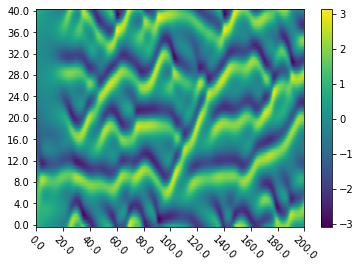

In [ ]:
if idx_arr[0].shape[0] != 0:
    plt.imshow(all_data[0:idx_arr[0][0]-int(0/delta_t)].transpose(), aspect='auto', origin='lower')
else:
    plt.imshow(all_data.transpose(), aspect='auto', origin='lower')
numtsteps = int( (T+0.1*delta_t)//delta_t )
xticks = np.linspace(0, numtsteps, 1+10, dtype=np.int32 )
plt.xticks(xticks, xticks*T/numtsteps, rotation=270+45)

# yticks = x_grid.copy()*len(x_grid)/x_grid[-1]
yticks = np.linspace(0, 1, 10+1)*(len(x_grid)-1)
yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*x_grid[-1], 2)

plt.yticks(yticks, yticklabels)
plt.colorbar()
plt.show()